In [2]:
import numpy as np
import scipy.integrate
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import DivergingNorm
import cmocean as cm

## The Equation

Consider the following heat equation:

$$
\frac{\partial T}{\partial t} = \frac{\partial}{\partial z} \bigg(\kappa \frac{\partial T}{\partial z}\bigg) + \bigg(\frac{Q}{\rho_0 c_p z_{\text{mix}}} - \lambda(T - T_0) \bigg) \times H(z_{\text{mix}}-z) + \text{C.A.}$$ 

where $T$ is the temperature, $\kappa$ is the *constant* (for the moment!) diffusivity, $Q$ is the prescribed surface heat flux, $\rho_0 = 1025$ kg m$^{-3}$ is the reference density, $c_p = 4000$ J/(kg C) is the specific heat capacity, $z_{\text{mix}}$ is the depth of the *mixing* layer (i.e., a minimum mixed layer), $\lambda$ acts like a climate feedback parameter which acts to restore the surface back to $T_0$, the equilibrium temperature. Finally $H$ represents a Heaviside function.

We will write a forward-time, central-space finite difference scheme for this equation.

In [7]:
### Define the forward-time, central-space finite difference scheme for the heat equation ###

# Constants

rho = 1025 # kg/m^3
c = 4000 # J/(kg C)
T_top = 18 # Top temperature before the beginning of the perturbation experiment
T_base = 6 # Bottom temperature before the beginning of the perturbation experiment

In [8]:
### Intermediate functions

def convective_adjustment(T):
    
    # These loops simplify the hidden code in the cell below which is shit but works and is also easier to understand in my head
    
    def mixing_Rahmstorf(T):
        
        for i in range(len(T) - 1):
            
            if T[i] < T[i + 1]:
                
                j = 0
                
                # This loop mixes the instability downwards
                
                while T[i + j] < T[i + j + 1]:
                    
                    T[i : i + j + 2] = np.mean(T[i : i + j + 2])
                    
                    j += 1
                    
                break
            
        return T
    
    
    # Run the Rahmstorf mixing algorithm until the instability has been eliminated from the water column (i.e., from the mixing layer) 
    
    for k in range(int(z_mix / dz)):
        
        mixing_Rahmstorf(T)
    
    return mixing_Rahmstorf(T)




def heaviside_mixing(z, z_mix):
    
    Hmix = np.empty(z.shape)
    
    for i in range(len(z)):
        
        if z[i] <= z_mix:
            Hmix[i] = 1
            
        else:
            Hmix[i] = 0
    
    return Hmix



def linear_stratification(z, z_mix, T_top, T_base):
    
    z_mix_index = (np.abs(z - z_mix)).argmin()
    
    T_mixing = np.array([T_top for i in range(len(z[ : z_mix_index - 1]))])
    
    T_stratified = (T_top - T_base) / (z[z_mix_index] - z[-1]) * z[z_mix_index : ] + (T_base * z[z_mix_index] - T_top * z[-1])/(z[z_mix_index] - z[-1])
    
    T = np.concatenate([T_mixing, T_stratified])
    
    return T

In [9]:
# def convective_adjustment(T):
    
#     def mixing(T):
    
#         for i in range(len(T) - 1):

#             if T[i] < T[i + 1]:
                
#                 T[i : i + 2] = np.mean(T[i : i + 2])
                
# #                 if T[i + 1] < T[i + 2]:

# #                     T[i : i + 3] = np.mean(T[i : i + 3])

# #                     if T[i + 2] < T[i + 3]:

# #                         T[i : i + 4] = np.mean(T[i : i + 4])

# #                         if T[i + 3] < T[i + 4]:

# #                             T[i : i + 5] = np.mean(T[i : i + 5])

# #                             if T[i + 4] < T[i + 5]:

# #                                 T[i : i + 6] = np.mean(T[i : i + 6])

# #                                 if T[i + 5] < T[i + 6]:

# #                                     T[i : i + 7] = np.mean(T[i : i + 7])

# #                                     if T[i + 6] < T[i + 7]:

# #                                         T[i : i + 8] = np.mean(T[i : i + 8])

# #                                         if T[i + 7] < T[i + 8]:

# #                                             T[i : i + 9] = np.mean(T[i : i + 9])

# #                                             if T[i + 8] < T[i + 9]:
    
# #                                                 T[i : i + 10] = np.mean(T[i : i + 10])

# #                                                 break
#         return T
    
# #     for j in range(int(z_mix / dz)): # number of times to mix each layer of mixing layer
        
# #         mixing(T)
                                  
#     return mixing(T)

In [10]:
# test = np.array([15., 15., 15., 15., 15., 18, 17.5, 17., 16.5, 16.0, 15.5, 15.])
# testcopy = np.array([15., 15., 15., 15., 15., 18, 17.5, 17., 16.5, 16.0, 15.5, 15.])

# # test_CA_step1 = [15., 15., 15., 15., 16.875, 16.875, 16.875, 16.875, 16.5, 16., 15.5, 15.]
# # test_CA_step2 = [15., 15., 15., 16.5, 16.5, 16.5, 16.5, 16.5, 16.5, 16., 15.5, 15.]
# #np.mean([16.0, 15.984375, 15.984375, 15.984375, 15.984375, 15.984375, 15.984375, 15.984375, 15.984375])

# np.cumsum(testcopy), np.cumsum(convective_adjustment(test))

In [11]:
### The forward in time, central in space scheme with restoring and flux boundary conditions


def FTCS(dt, dz, kappa, lambd, z_mix, T_initial, Q, years):
    
    # Data
    
    forcing = Q / (c * rho * z_mix)
    days = dt / 86400 # Timestep in days
    thermocline_depth = 1000 # Base of thermocline = 1000m
    M = int(thermocline_depth / dz) # Number of spatial steps
    N = int(years * 360 / days) # Number of timesteps in days (taking 1 year = 360 days)
    z = np.linspace(0.0, 1000, M + 1)
    t = np.linspace(0.0, years * 360, N + 1)
    Hmix = heaviside_mixing(z, z_mix)
    
    
    # Temperature and flux matrices. Prescribe initial and boundary conditions
    
    T = np.zeros((M, N + 1))
    F = np.zeros((M + 1, N + 1))
    
    T[:, 0] = T_initial # Initial conditions
    F[0, :] = 0 # No flux at surface
    F[-1, :] = 0 # No flux at base
    
    for n in range(0, N):
        
        for m in range(1, M):
            
            F[m, n] = kappa / dz * (T[m - 1, n] - T[m, n])
            
        for m in range(0, M):
            
            T[m, n + 1] = T[m, n] + dt / dz * (F[m, n] - F[m + 1, n]) + dt * (forcing - lambd * (T[m, n] - T0)) * Hmix[m + 1]

        #Convective adjustment step
    
        convective_adjustment(T[:, n + 1])
        
    return T, z, t

In [12]:
### Functions that run cwcw/wcwc experiments

def cwcw(T_initial, cycles):
    
    cool = FTCS(dt, dz, kappa, lambd, z_mix, T_initial, - Q, years)[0]
    
    cwcw_expt = cool
    
    for i in range(cycles):
        
        warm = FTCS(dt, dz, kappa, lambd, z_mix, cool[:, - 1], Q, years)[0] 
        cwcw_expt = np.concatenate((cwcw_expt, warm[:, : - 1]), axis = 1)
        # Don't include the last timestep, as this is included in the following array
        
        cool = FTCS(dt, dz, kappa, lambd, z_mix, warm[:, - 1], - Q, years)[0]
        cwcw_expt = np.concatenate((cwcw_expt, cool[:, : - 1]), axis = 1)
        # Don't include the last timestep, as this is included in the following array
        # Somehow want to include the last timestep IF we are at the last cycle
        
    return cwcw_expt



def wcwc(T_initial, cycles):
    
    warm = FTCS(dt, dz, kappa, lambd, z_mix, T_initial, Q, years)[0]
    wcwc_expt = warm
    
    for i in range(cycles):
        
        cool = FTCS(dt, dz, kappa, lambd, z_mix, warm[:, - 1], - Q, years)[0]
        wcwc_expt = np.concatenate((wcwc_expt, cool[:, : - 1]), axis = 1) # Don't include the last timestep, as this is included in the following array
        
        warm = FTCS(dt, dz, kappa, lambd, z_mix, cool[:, - 1], Q, years)[0]
        wcwc_expt = np.concatenate((wcwc_expt, warm[:, : - 1]), axis = 1) # Don't include the last timestep, as this is included in the following array
        # Somehow want to include the last timestep IF we are at the last cycle
        
    return wcwc_expt



### Ocean heat content

def OHC(T):
    
    return rho * c * np.cumsum(T)[-1] * dz
    #return np.mean(T)



def OHC_time(T_time):
    
    OHC_time = np.empty(T_time.shape[1])
    
    for i in range(len(OHC_time)):
        
        OHC_time[i] = OHC(T_time[: , i])
        
    return OHC_time

In [13]:
# Data and parameters

dt = 10.0 * 86400 # units: s
dz = 5 # units: m
kappa = 1e-6 # units: m^2/s

z = np.arange(0, 1000 + dz, dz)
z_mix = 30.0
T_i = linear_stratification(z, z_mix, T_top, T_base)

lambd = 1/(365 * 5 * 86400)
T0 = 18 # temeprature relaxed back to
Q = 8
years = 10

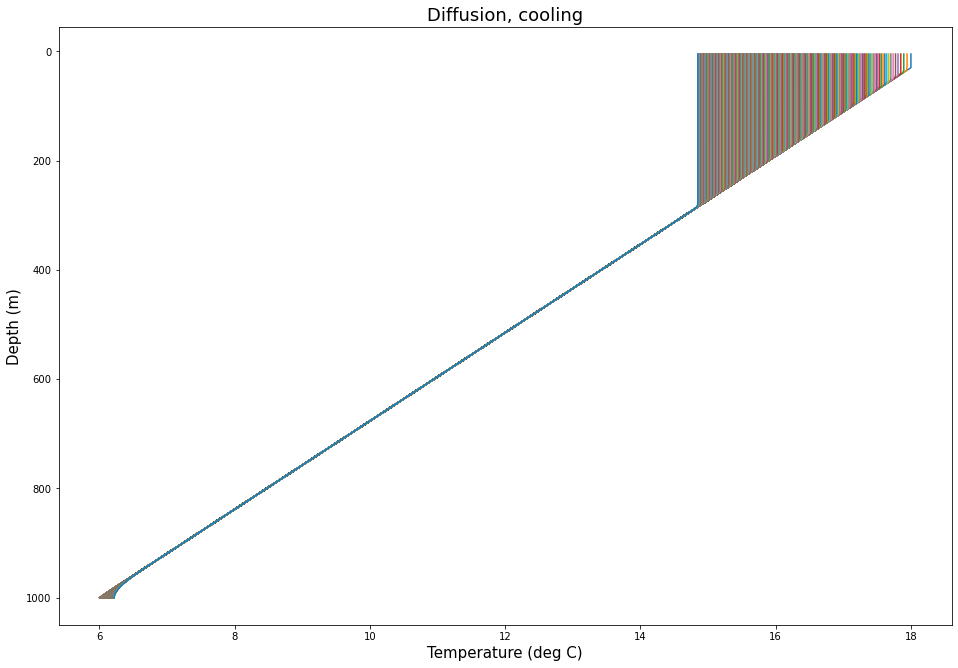

In [14]:
# Cooling
t = FTCS(dt, dz, kappa, lambd, z_mix, T_i, - Q, years)[2]
T_c = FTCS(dt, dz, kappa, lambd, z_mix, T_i, - Q, years)[0]
T_w = FTCS(dt, dz, kappa, lambd, z_mix, T_i, Q, years)[0]

plt.figure(figsize=(16,11))

plt.plot(T_c[:, :], z[1 : ])
#plt.plot(T_i, z[1 : ])
#plt.plot(T_w[:, :], z[1 : ])

plt.title('Diffusion, cooling', fontsize = 18)
plt.xlabel('Temperature (deg C)', fontsize = 15)
plt.ylabel('Depth (m)', fontsize = 15)
plt.gca().invert_yaxis()
#plt.savefig('Temperature_10c.jpg')

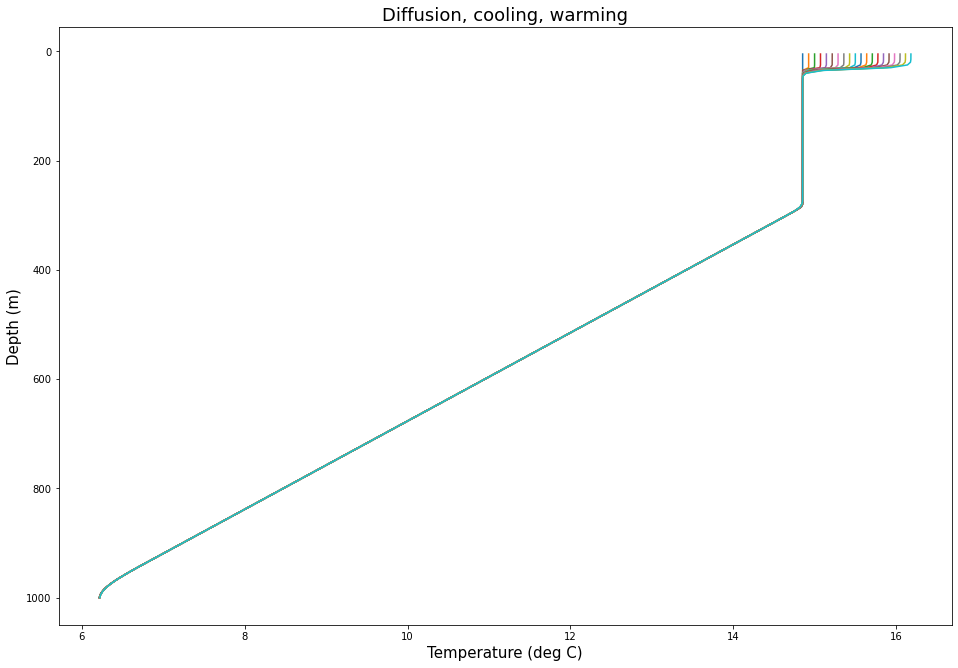

In [15]:
# Warming

T_cw = FTCS(dt, dz, kappa, lambd, z_mix, T_c[:, - 1], Q, years)[0]

plt.figure(figsize=(16,11))

# plt.plot(T_i, z, label='Initial')
# plt.plot(T_c[:,-1], z, label='10 years cool')
# plt.plot(T_cw[:,-1], z, label='10 years warm after cool')

plt.plot(T_cw[:,:20], z[1 : ])

plt.title('Diffusion, cooling, warming', fontsize = 18)
plt.xlabel('Temperature (deg C)', fontsize = 15)
plt.ylabel('Depth (m)', fontsize = 15)
plt.gca().invert_yaxis()
#plt.legend()
#plt.savefig('Temperature_10c10w.jpg')

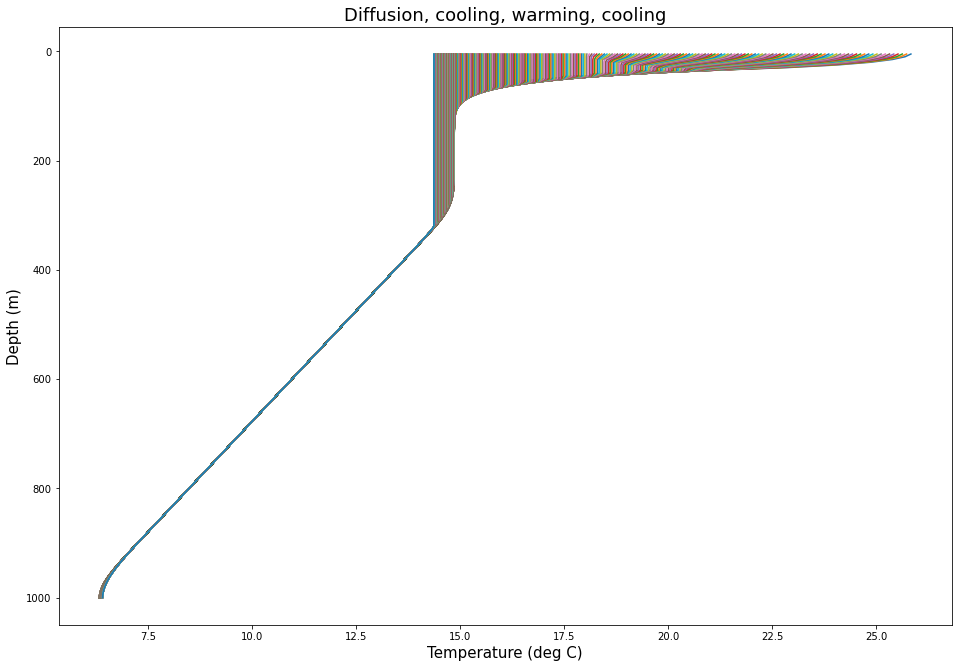

In [16]:
# Cooling, warming, cooling

T_cwc = FTCS(dt, dz, kappa, lambd, z_mix, T_cw[:, - 1], - Q, years)[0]

plt.figure(figsize=(16,11))

plt.plot(T_cwc[:, :], z[1:])

plt.title('Diffusion, cooling, warming, cooling', fontsize = 18)
plt.xlabel('Temperature (deg C)', fontsize = 15)
plt.ylabel('Depth (m)', fontsize = 15)
plt.gca().invert_yaxis()

In [17]:
# 'Run' the experiment

cwcw_expt = cwcw(T_i, int(500 / 2 / years))
wcwc_expt = wcwc(T_i, int(500 / 2 / years))

# Q = 0
# cwcw_exptnoQ = cwcw(T_i, int(600 / 2 / years))
# wcwc_exptnoQ = wcwc(T_i, int(600 / 2 / years))

In [13]:
# plt.plot(cwcw_expt[:,1400],z[1:])
# plt.plot(cwcw_expt[:,-50],z[1:])
# plt.gca().invert_yaxis()

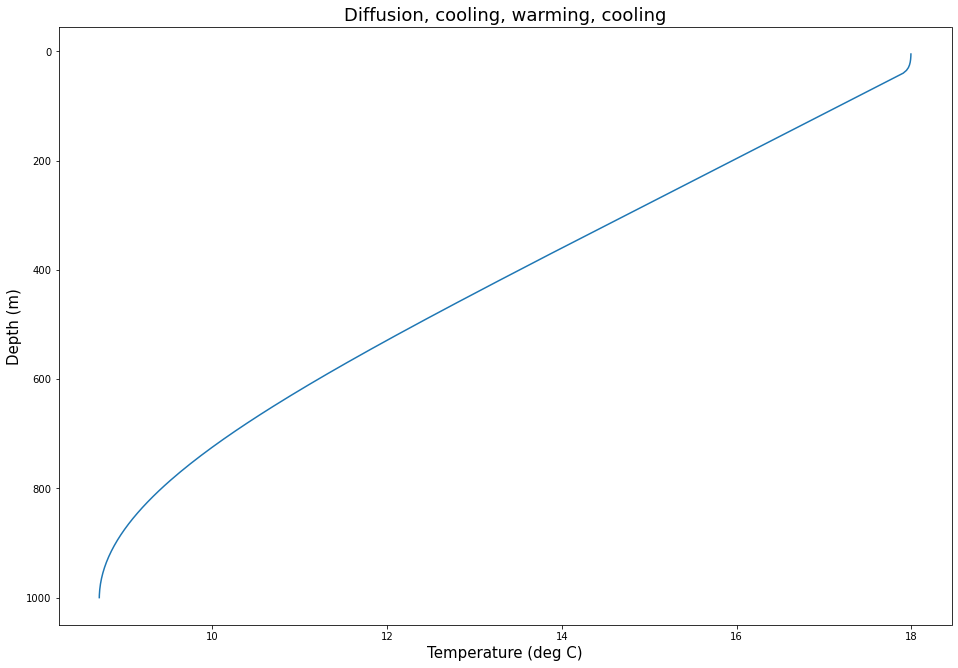

In [41]:
# # Cooling, warming, cooling

# plt.figure(figsize=(16,11))

# plt.plot(cwcw_expt[:, -1], z[1:])

# plt.title('Diffusion, cooling, warming, cooling', fontsize = 18)
# plt.xlabel('Temperature (deg C)', fontsize = 15)
# plt.ylabel('Depth (m)', fontsize = 15)
# plt.gca().invert_yaxis()

In [250]:
# OHC_resolution_fin = np.empty(5)
# dzs = [2., 4., 8., 20., 40.]

# for i in range(3):
#     dz = dzs[i]
#     z = np.arange(0, 1000 + dz, dz)
#     T_i = linear_stratification(z, z_mix, T_top, T_base)
#     cwcw_expt = cwcw(T_i, 2)
#     OHC_cwcw = OHC_time(cwcw_expt)
#     OHC_resolution_fin[i] = OHC_cwcw[-1]

In [18]:
# Calculate ocean heat content

OHC_cwcw = OHC_time(cwcw_expt)
OHC_wcwc = OHC_time(wcwc_expt)

# OHC_cwcwnoQ = OHC_time(cwcw_exptnoQ)
# OHC_wcwcnoQ = OHC_time(wcwc_exptnoQ)

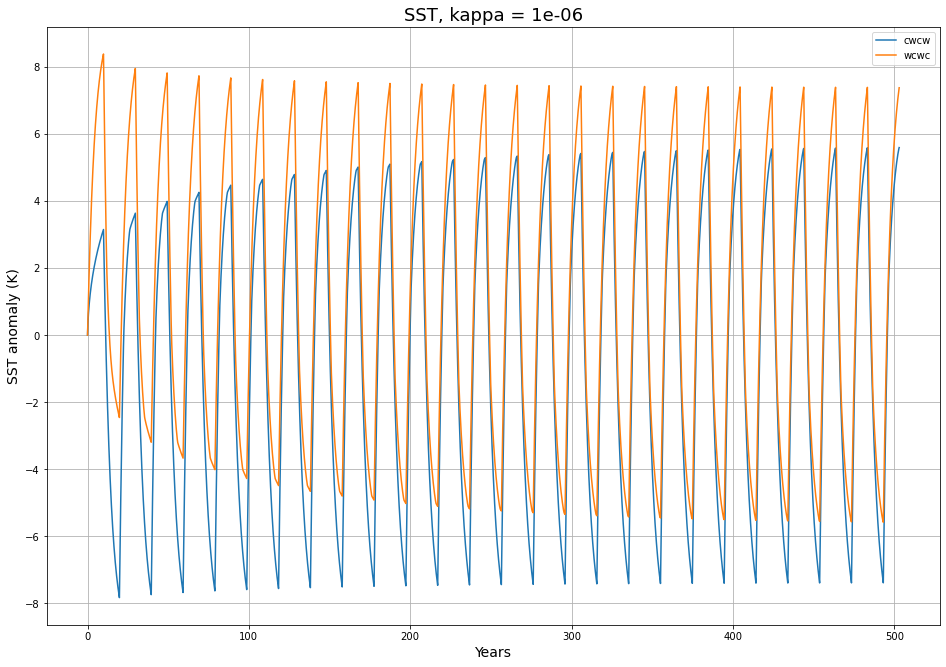

In [19]:
# SST over time

plt.figure(figsize=(16,11))

days = dt / 86400
timesteps = cwcw_expt.shape[1]
length = (timesteps - 1) * days / 365

plt.plot(np.linspace(0, length, timesteps), -1*(cwcw_expt[0, :] - 18), label='cwcw')
plt.plot(np.linspace(0, length, timesteps), wcwc_expt[0, :] - 18, label='wcwc')

# plt.plot(np.linspace(0, length, timesteps), cwcw_expt[0, :], label='SST')
# plt.plot(np.linspace(0, length, timesteps), cwcw_expt[-1, :], label='Base temp')

plt.grid()
plt.title('SST, kappa = {}'.format(kappa), fontsize = 18)
plt.ylabel('SST anomaly (K)', fontsize = 14)
plt.xlabel('Years',fontsize = 14)
plt.legend()
#plt.savefig('SST anomaly, kappa = {}, Q = {}, T0 = {}.jpg'.format(kappa, Q, T_pert))

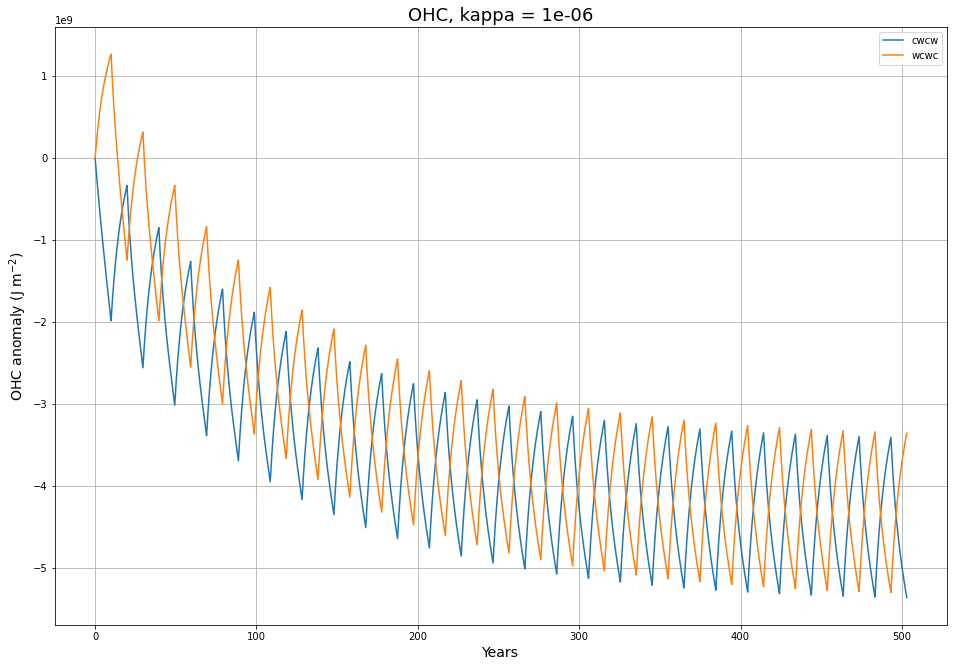

In [20]:
# Ocean heat content over time

plt.figure(figsize=(16,11))

days = dt / 86400
timesteps = cwcw_expt.shape[1]
length = (timesteps - 1) * days/365 

OHC_cwcw_anom = OHC_cwcw - OHC(T_i)
OHC_wcwc_anom = OHC_wcwc - OHC(T_i)

# OHC_cwcwnoQ_anom = OHC_cwcwnoQ - OHC(T_i)
# OHC_wcwcnoQ_anom = OHC_wcwcnoQ - OHC(T_i)

# OHC_cwcw_detrend_anom = OHC_cwcw_anom - OHC_cwcwnoQ_anom

plt.plot(np.linspace(0,length,timesteps), 1*OHC_cwcw_anom, label='cwcw')
plt.plot(np.linspace(0,length,timesteps), OHC_wcwc_anom, label='wcwc')

# plt.plot(np.linspace(0,length,timesteps), OHC_cwcwnoQ_anom, label='cwcw, no Q')
# plt.plot(np.linspace(0,length,timesteps), OHC_cwcw_detrend_anom, label='cwcw, detrend')

plt.grid()

plt.title('OHC, kappa = {}'.format(kappa), fontsize = 18)
plt.ylabel('OHC anomaly (J m$^{-2}$)', fontsize = 14)
plt.xlabel('Years', fontsize = 14)
plt.legend()
#plt.savefig('OHC, kappa = {}, Q = {}.jpg'.format(kappa, Q))

In [517]:
# cwcw_peaks = np.array([OHC_cwcw_anom[361 + 360 * i] for i in range(int((len(OHC_cwcw_anom) - 361) / 360))])
# wcwc_peaks = np.array([OHC_wcwc_anom[361 + 360 * i] for i in range(int((len(OHC_wcwc_anom) - 361) / 360))])

# cwcw_peaks

array([-2.04501441e+08,  3.08397814e+07, -2.07065912e+08,  2.92616004e+07,
       -2.07384680e+08,  2.90654300e+07, -2.07460355e+08,  2.90188598e+07,
       -2.07486564e+08,  2.90027303e+07, -2.07497911e+08,  2.89957474e+07,
       -2.07503520e+08,  2.89922954e+07])

In [204]:
# # Plot (scaled) ocean heat content anomaly

# plt.figure(figsize=(16,11))

# plt.plot(-1*(OHC_time(T_c, z)-OHC(T_c[:,0],z)), label='Cooling (times -1)')
# plt.plot((OHC_time(T_w, z)-OHC(T_w[:,0],z)), label='Warming')
# plt.title('Ocean heat content anomaly: cooling v warming',fontsize=18)
# plt.ylabel('OHC anomaly (J)',fontsize=14)
# plt.xlabel('Years',fontsize=14)

# plt.legend()
# #plt.savefig('OHC, cooling v warming.jpg')

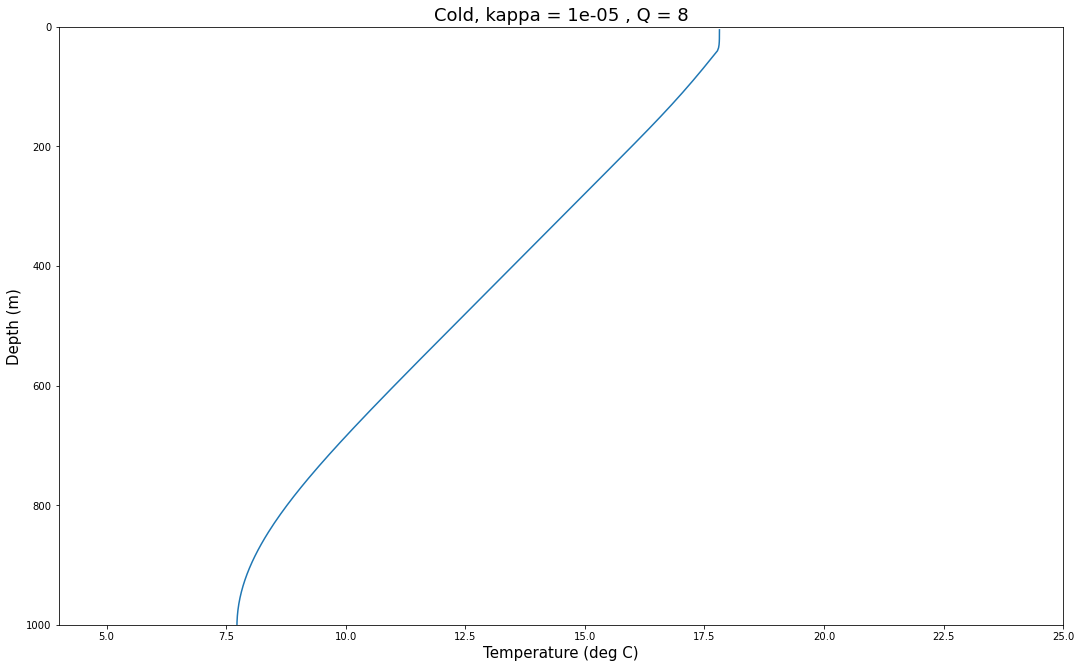

In [907]:
#Animate the forcing

cwcw_expt_50years = cwcw_expt[:, : 1800]

fig = plt.figure(figsize=(18,11))
ax = plt.axes(xlim=(4, 25), ylim=(z[0], z[-1]))

line, = plt.plot([], [])

def init():
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(cwcw_expt_50years[:, i], z[1 : ])
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(cwcw_expt_50years[0, :]), interval=50, blit=True)

title = 'Cold, kappa = {} , Q = {}'.format(kappa, Q)

ax.set_title(title, fontsize = 18)
ax.set_xlabel('Temperature (deg C)', fontsize = 15)
ax.set_ylabel('Depth (m)', fontsize = 15)
ax.invert_yaxis()

anim.save('Cold, kappa = {}, Q = {}.mp4'.format(kappa, Q))
#plt.show()

In [47]:
### Hovmoller plot

plt.figure(figsize=(19,13))

t_expt = np.linspace(0, 150, 5401)
tt, zz = np.meshgrid(t_expt, z)
#cwcw_expt_150years_anom = cwcw_expt_150years - T_i[..., np.newaxis]
wcwc_expt_150years_anom = wcwc_expt_150years - T_i[..., np.newaxis]

cmap = cm.cm.balance
Tmin = np.min(cwcw_expt_150years_anom)
Tmax = np.max(cwcw_expt_150years_anom)


plt.contourf(tt, zz, cwcw_expt_150years_anom, levels=51, cmap=cmap, norm=DivergingNorm(0))
plt.colorbar().set_label(label='Temperature (deg C)', size=16)

plt.title('Hovmoller plot, cwcw experiment, anomaly', fontsize = 18)
plt.xlabel('Years', fontsize = 15)
plt.ylabel('Depth (m)', fontsize = 15)
plt.gca().invert_yaxis()
#plt.savefig('Hovmoller, wcwc.jpg')

NameError: name 'cwcw_expt_150years_anom' is not defined

<Figure size 1368x936 with 0 Axes>

## Sinusoidal forcing

We will now consider forcing of the form $F = F_0 \sin(\omega t),$ so that the equation to be solved is now $$\frac{\partial T}{\partial t} = \frac{\partial}{\partial z} \Big(\kappa \frac{\partial T}{\partial z}\Big) + \big(F_0 \sin(\omega t)\big) \times H(z_{\text{mix}}-z),$$ where $F_0$ is the amplitude of the forcing and $\omega$ is its frequency.

In [286]:
### Sinusoidal forcing

def FTCS_sinusoidal(dt, dz, kappa, lambd, z_mix, T_initial, Q, years):
    # Data
    
    alpha = kappa * dt / dz**2
    heat_flux = Q / (c * rho * z_mix)
    omega = np.pi / (10 * 365) # Frequency of forcing
    
    days = dt / 86400 # Timestep in days
    
    thermocline_depth = 1000 # Base of thermocline = 1000m
    M = int(thermocline_depth / dz) # Number of spatial steps
    N = int((365 / days) * years) # Number of timesteps in days
    
    z = np.linspace(0.0, 1000, M+1)
    t = np.linspace(0.0, 365 * years, N+1)
    
    Hmix = heaviside_mixing(z, z_mix)
    
    # Temperature matrix
    
    T = np.empty((M+1, N+1))
    T[:,0] = T_initial
    T[M,:] = T_base
    #flux = np.empty(N)
    
    for n in range(0, N):
        for m in range(0, M):

            # Diffusion and sinusoidal flux
            #T[m, n+1] = alpha * T[m + 1, n] + (1 - 2 * alpha) * T[m, n] + alpha * T[m-1, n]# + dt * heat_flux * np.sin(t[n] * omega) * Hmix[m]
            T[m, n+1] = T[m, n] + dt * heat_flux * np.sin(t[n+1] * omega) * Hmix[m] 
            
            # Convective adjustment step
        convective_adjustment(T[:,n+1])
        #flux[n] = dt * heat_flux * np.sin(t[n+1] * omega)
        
    return T, z, t

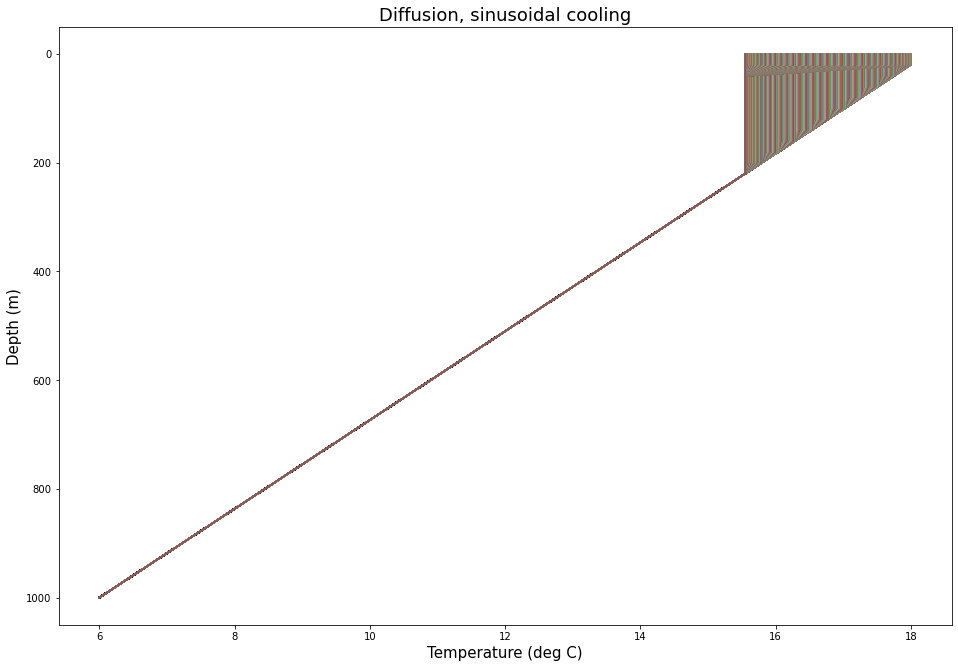

In [290]:
Q = 1
years = 30
T_sin = FTCS_sinusoidal(dt, dz, kappa, lambd, z_mix, T_initial, -Q, years)[0]

plt.figure(figsize=(16,11))

plt.plot(T_c_sin[:,:], z[:])

plt.title('Diffusion, sinusoidal cooling', fontsize = 18)
plt.xlabel('Temperature (deg C)', fontsize = 15)
plt.ylabel('Depth (m)', fontsize = 15)
plt.gca().invert_yaxis()

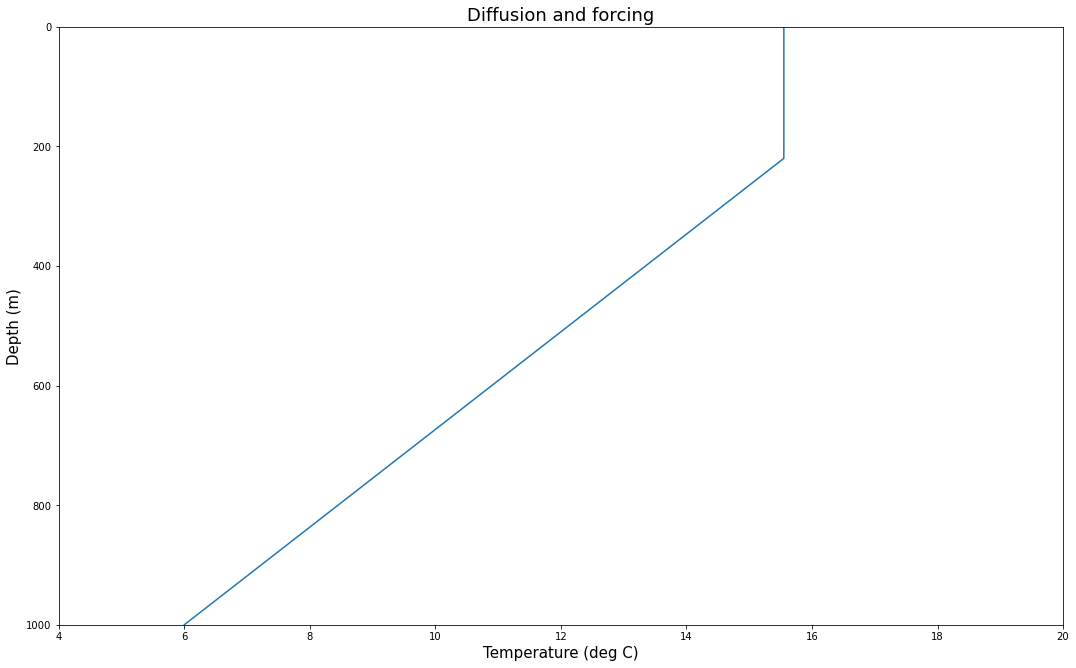

In [291]:
#Animate the forcing

fig = plt.figure(figsize=(18,11))
ax = plt.axes(xlim=(4, 20), ylim=(z[0], z[-1]))

line, = plt.plot([], [])

def init():
    line.set_data([], [])
    return line,

def animate(i):
    line.set_data(T_sin[:,i], z)
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(t), interval=50, blit=True)

ax.set_title('Diffusion and forcing', fontsize = 18)
ax.set_xlabel('Temperature (deg C)', fontsize = 15)
ax.set_ylabel('Depth (m)', fontsize = 15)
ax.invert_yaxis()

anim.save('Diffusion_sinusoidal.mp4')
#plt.show()

In [70]:
### Define functions for cwcw with oscillory forcing

def cwcw_sinusoidal(T_initial, cycles):
    
    cool = FTCS_sinusoidal(dt, dz, kappa, lambd, z_mix, T_initial, -Q, years)[0]
    cwcw_expt = cool
    
    for i in range(cycles):
        
        warm = FTCS_sinusoidal(dt, dz, kappa, lambd, z_mix, cool[:,-1], Q, years)[0]
        cwcw_expt = np.concatenate((cwcw_expt, warm), axis=1)
        
        cool = FTCS_sinusoidal(dt, dz, kappa, lambd, z_mix, warm[:,-1],  -Q, years)[0]
        cwcw_expt = np.concatenate((cwcw_expt, cool), axis=1)
        
    return cwcw_expt



def wcwc_sinusoidal(T_initial, cycles):
    
    warm = FTCS_sinusoidal(dt, dz, kappa, lambd, z_mix, T_initial, Q, years)[0]
    wcwc_expt = warm
    
    for i in range(cycles):
        
        cool = FTCS_sinusoidal(dt, dz, kappa, lambd, z_mix, warm[:,-1], -Q, years)[0]
        wcwc_expt = np.concatenate((wcwc_expt, cool), axis=1)
        
        warm = FTCS_sinusoidal(dt, dz, kappa, lambd, z_mix, cool[:,-1], Q, years)[0]
        wcwc_expt = np.concatenate((wcwc_expt, warm), axis=1)
        
    return wcwc_expt

In [71]:
# 'Run' the experiment and calculate ocean heat content

cwcw_expt_150years_sinusoidal = cwcw_sinusoidal(T_initial, 7)
wcwc_expt_150years_sinusoidal = wcwc_sinusoidal(T_initial, 7)

OHC_cwcw_150years_sinusoidal = OHC_time(cwcw_expt_150years_sinusoidal, z)
OHC_wcwc_150years_sinusoidal = OHC_time(wcwc_expt_150years_sinusoidal, z)

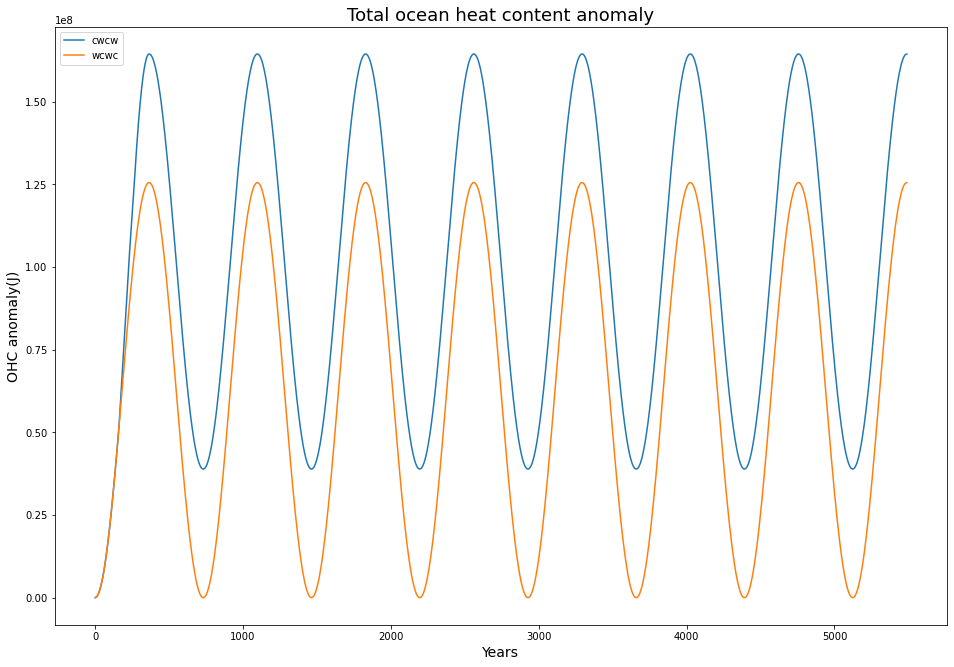

In [73]:
# Plot (scaled) ocean heat content anomaly

plt.figure(figsize=(16,11))

# plt.plot(np.linspace(0,150,5490), OHC_cwcw_150years_sinusoidal, label='cwcw')
# plt.plot(np.linspace(0,150,5490), OHC_wcwc_150years_sinusoidal, label='wcwc')

plt.plot(-1*(OHC_cwcw_150years_sinusoidal-OHC(T_initial, z)), label='cwcw')
plt.plot(OHC_wcwc_150years_sinusoidal-OHC(T_initial, z), label='wcwc')

plt.title('Total ocean heat content anomaly',fontsize=18)
plt.ylabel('OHC anomaly(J)',fontsize=14)
plt.xlabel('Years',fontsize=14)

plt.legend()

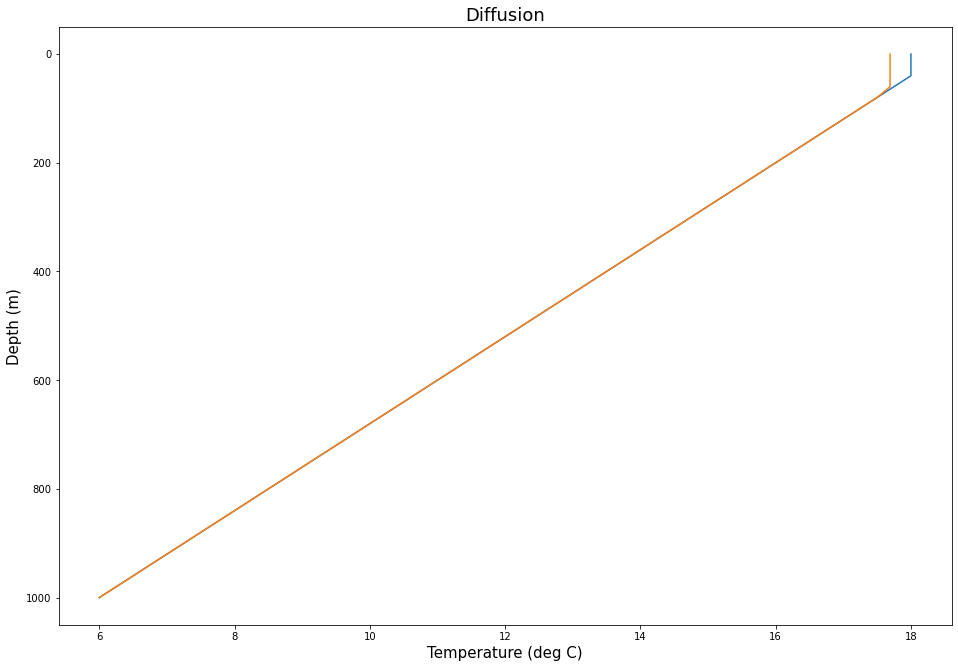

In [494]:
plt.figure(figsize=(16,11))

# Gets standard colours used my matplotlib.pyplot
prop_cycle = plt.rcParams['axes.prop_cycle']
colours = prop_cycle.by_key()['color']

# Use plt.step for mixed layer and above, use plt.plot for everything else

### I need the mixed layer depth from each T array


# Initial
plt.plot(T_c[:,:2], z)

# plt.step(T_c_beforeitbecomesfucked[:(np.abs(z - z_mix)).argmin()+2,1], z[:(np.abs(z - z_mix)).argmin()+2], color=colors[0])
# plt.plot(T_c_beforeitbecomesfucked[(np.abs(z - z_mix)).argmin()+1:,1], z[(np.abs(z - z_mix)).argmin()+1:], color=colors[0])

# # Warming
# for i in range(len(T_cw_beforeitbecomesfucked[0,:])):
#     plt.step(T_cw_beforeitbecomesfucked[:(np.abs(z - z_mix)).argmin()+2,i], z[:(np.abs(z - z_mix)).argmin()+2], color=colors[i % 10])
#     plt.plot(T_cw_beforeitbecomesfucked[(np.abs(z - z_mix)).argmin()+1:,i], z[(np.abs(z - z_mix)).argmin()+1:], color=colors[i % 10])

plt.title('Diffusion', fontsize = 18)
plt.xlabel('Temperature (deg C)', fontsize = 15)
plt.ylabel('Depth (m)', fontsize = 15)
plt.gca().invert_yaxis()